<a href="https://colab.research.google.com/github/zostaw/learning-regression-methods/blob/main/ridge-regression-ellipsoids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as random

import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
from matplotlib.patches import Circle
import seaborn as sns

import pandas as pd
from sklearn.linear_model import Ridge
from mpl_toolkits.mplot3d import Axes3D

# Where does *elipsoid* in *Ridge Regression* come from

In Ridge Regression we want to find the parameters $\beta$ that minimize the residual sum of squares:

$$
RSS = \sum_{i=1}^N \big( y_i - \sum_{j=1}^p \beta_j x_{ij} \big)^2 + \lambda \sum_{j=1}^p ||\beta_j||^2
$$

or as vector operations:

$$
RSS =  \big( Y -  X \beta \big)^T \big( Y -  X \beta \big) + \lambda  \beta^T\beta = \\
= Y^TY - Y^TX\beta - \beta^TX^TY + X^T\beta^TX\beta + \lambda \beta^T\beta = \\
= Y^TY - 2\beta^TX^TY + \beta^TX^TX\beta + \lambda \beta^T\beta
$$
where $N$ is number of samples and $p$ is dimensionality of the feature space.  
To find it, we usually calculate the derivative $\frac{\partial{RSS}}{\partial{\beta}}$ to find the optimal solution:
$$
\frac{\partial{RSS}}{\partial{\beta}} = -2X^TY + 2X^TX\beta + 2 \lambda \beta = 0
$$

$$
\hat{\beta}^{ridge} = (X^TX + \lambda I)^{-1}X^TY
$$

where, $I$ is a $(p, p)$ identity matrix ($X^TX$ is a $(p,p)$ matrix, but $\lambda$ itself is a scalar, hence we introduce this additional identity matrix).  

The visual interpretation of the optimal solution for Ridge Regression is the point of tangency between the hypersphere (blue circle) of parameter constraint boundary and the $RSS_{OLS}$ ellipsoid (OLS stands for Ordinary Least Squares, in other words this is RSS for ordinary Linear Regression):  
!["The Elements of Statistical Learning" by Trevor Hastie, Robert Tibshirani, Jerome Friedman, Second Edition, page 71](https://drive.google.com/uc?id=13Crq7HY8f6OIpi-V0797ejDuVo-TZcnD '"The Elements of Statistical Learning" by Trevor Hastie, Robert Tibshirani, Jerome Friedman, Second Edition, page 71')  


And so the question is: how to interpret the sphere and the elipse - why do they have the shape they do?

In [ ]:
# let's pick a dataset that has RSS_OLS for betas outside b^2 + b^2 = 1, to make it a good example
key = random.key(69)
key, key1, key2 = random.split(key, 3)
N = 1000
p = 2
x1 = random.uniform(key1, (N, 1), minval=-1, maxval=1)
x2 = x1 + random.normal(key2, (N, 1))
X = jnp.hstack([x1, x2])
y = 150*jnp.cos(X[:, 0]) + 15*jnp.cos(X[:, 1])

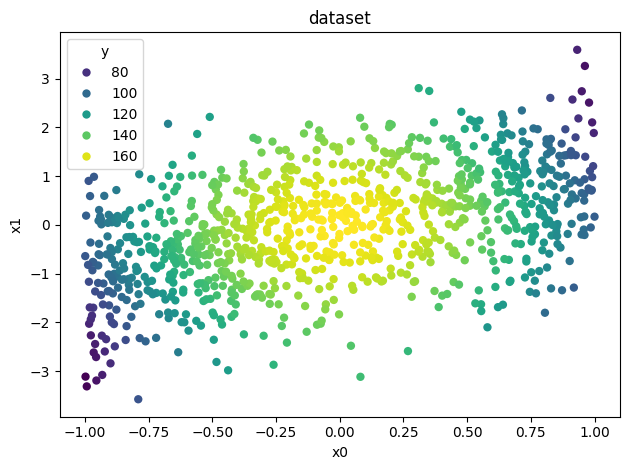

In [ ]:
df = pd.DataFrame({
    "x0": jnp.asarray(X[:, 0]),
    "x1": jnp.asarray(X[:, 1]),
    "y" : jnp.asarray(y).ravel(), # flatten to 1‑D
})

ax = sns.scatterplot(data=df, x="x0", y="x1",
                     hue="y", palette="viridis", edgecolor="none")

plt.title("dataset")
plt.tight_layout()
plt.show()

In [ ]:
# Linear Regression (lambda/alpha = 0)
clf_ols = Ridge(alpha=0.0) # scikit uses alpha instead of lambda - it's the same thing
clf_ols.fit(X, y)
beta, intercept, _lambda = clf_ols.coef_, clf_ols.intercept_, clf_ols.alpha
beta, intercept, _lambda

(array([-1.6074886,  2.4778876], dtype=float32), np.float32(135.05278), 0.0)

In [ ]:
def RSS_OLS(beta1, beta2):
    clf_ols.coef_ = jnp.array([beta1, beta2])
    return jnp.dot((y - clf_ols.predict(X)).reshape(-1,1).T, (y - clf_ols.predict(X)).reshape(-1,1)).reshape(1,)

# vector and matrix mapping functions
RSS_array = jax.vmap(RSS_OLS)
RSS_mat = jax.vmap(RSS_array)

RSS_OLS(beta[0], beta[1])

Array([521460.5], dtype=float32)

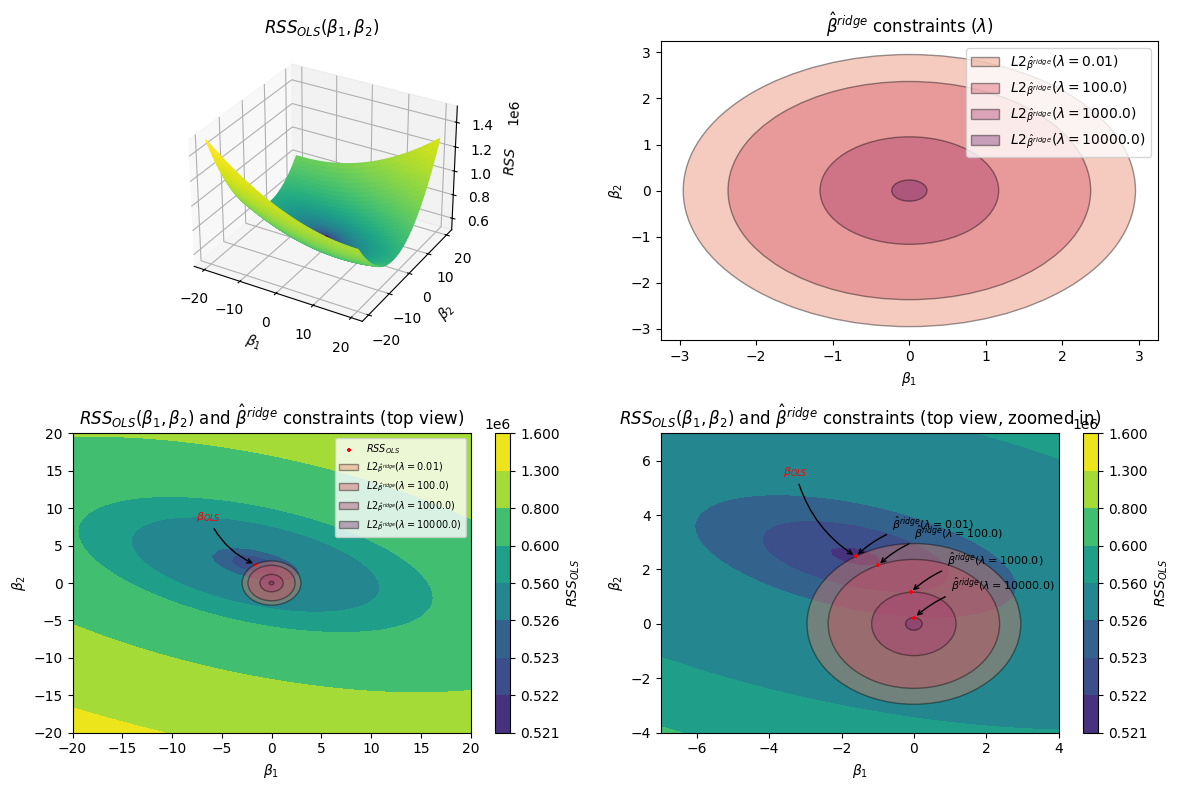

In [ ]:
sample_length = 50
high_scale_range = 20

# hand-picked lambda values
lambdas = [0.01, 1e2, 1e3, 1e4]
# palette for lambdas plots to not confuse with RSS_OLS colors
palette = sns.color_palette("flare", n_colors=len(lambdas))

"""
AX[0,0] - RSS_OLS plot
"""
b_1 = jnp.linspace(-high_scale_range, high_scale_range, sample_length).reshape(-1,1)
b_2 = jnp.linspace(-high_scale_range, high_scale_range, sample_length).reshape(-1,1)
B1, B2 = np.meshgrid(b_1, b_2)

Z = RSS_mat(B1,B2).reshape(sample_length, sample_length)

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(2,2,1, projection='3d')
ax0.plot_surface(B1, B2, Z,
                 cmap='viridis',
                 facecolors=plt.cm.viridis(PowerNorm(gamma=0.2)(Z)),
                 )
ax0.set_xlabel(r'$\beta_1$'); ax0.set_ylabel(r'$\beta_2$'); ax0.set_zlabel('$RSS$')
plt.title(r"$RSS_{OLS}(\beta_1, \beta_2)$")





"""
This is used for all plots where beta constraints are plotted
"""
# generate lambda constraints' circles
betas_transparency = 0.4
beta_constraints = []
for id, _lambda in enumerate(lambdas):
    clf_ = Ridge(alpha=_lambda)
    clf_.fit(X, y)
    betas_ = clf_.coef_

    betas_norm = jnp.sqrt(jnp.dot(betas_, betas_))
    circle_ax1 =  Circle((0,0), radius=betas_norm, edgecolor='black', facecolor=palette[id], alpha=betas_transparency, label=r'$L2_{\hat{\beta}^{ridge}}(\lambda=' + str(_lambda) + ')$')
    circle_ax2 =  Circle((0,0), radius=betas_norm, edgecolor='black', facecolor=palette[id], alpha=betas_transparency, label=r'$L2_{\hat{\beta}^{ridge}}(\lambda=' + str(_lambda) + ')$')
    circle_ax3 =  Circle((0,0), radius=betas_norm, edgecolor='black', facecolor=palette[id], alpha=betas_transparency, label=r'$L2_{\hat{\beta}^{ridge}}(\lambda=' + str(_lambda) + ')$')
    beta_constraints.append({'circle_ax1': circle_ax1,
                             'circle_ax2': circle_ax2,
                             'circle_ax3': circle_ax3,
                             'betas': betas_,
                             'betas_norm': betas_norm,
                             'lambda': _lambda,
                             'text': r"$\hat{\beta}^{ridge}(\lambda=" + str(_lambda) + ")$"
                             })

# necessary to display tangents between RSS_OLS contours and beta constraints
contour_levels = [rss_level.item() for rss_level in [RSS_OLS(annot['betas'][0], annot['betas'][1]) for annot in beta_constraints]]
contour_levels.extend([560_000, 600_000, 800_000, 1_300_000, 1_600_000])





"""
AX[0,1] - Top view - just lambda constraints for different lambda
"""
ax1 = fig.add_subplot(2,2,2)
ax1.set_xlabel(r'$\beta_1$'); ax1.set_ylabel(r'$\beta_2$')
ax1.plot()

for constraint in beta_constraints:
    ax1.add_patch(constraint['circle_ax1'])

plt.legend()
plt.title(r"$\hat{\beta}^{ridge}$ constraints ($\lambda$)")





"""
AX[1,0] - Top view - high scale
"""
ax2 = fig.add_subplot(2,2,3)
cs = ax2.contourf(B1, B2, Z, levels=contour_levels, norm=PowerNorm(gamma=0.2))
ax2.set_xlabel(r'$\beta_1$'); ax2.set_ylabel(r'$\beta_2$')
plt.colorbar(cs, ax=ax2, label=r'$RSS_{OLS}$')
plt.title(r"$RSS_{OLS}(\beta_1, \beta_2)$ and $\hat{\beta}^{ridge}$ constraints (top view)")
ax2.scatter(beta[0], beta[1], c='red', label=r"$RSS_{OLS}$", marker='+', s=10)
ax2.annotate(
    r"$\beta_{OLS}$",
    xy=(beta[0], beta[1]),             # point to annotate
    xytext=(beta[0]-6, beta[1]+6),   # where to place the text
    arrowprops=dict(         # draw an arrow
        arrowstyle="->",
        connectionstyle="arc3,rad=0.2"
    ),
    fontsize=8,
    color="red"
)

for constraint in beta_constraints:
    ax2.add_patch(constraint['circle_ax2'])

plt.legend(fontsize=7)





"""
AX[1,1] - Top view - zoomed in
"""
# generate surface for RSS_OLS
b_1 = jnp.linspace(-7, 4, sample_length).reshape(-1,1)
b_2 = jnp.linspace(-4, 7, sample_length).reshape(-1,1)
B1, B2 = np.meshgrid(b_1, b_2)
Z = RSS_mat(B1,B2).reshape(sample_length, sample_length)

# generate the RSS_OLS meshgrid
ax3 = fig.add_subplot(2,2,4)
cs = ax3.contourf(B1, B2, Z, levels=contour_levels, norm=PowerNorm(gamma=0.2))
ax3.set_xlabel(r'$\beta_1$'); ax3.set_ylabel(r'$\beta_2$')
plt.colorbar(cs, ax=ax3, label=r'$RSS_{OLS}$')
plt.title(r"$RSS_{OLS}(\beta_1, \beta_2)$ and $\hat{\beta}^{ridge}$ constraints (top view, zoomed in)")
ax3.scatter(beta[0], beta[1], c='red', label=r"$RSS_{OLS}$", marker='+', s=10)
ax3.annotate(
    r"$\beta_{OLS}$",
    xy=(beta[0], beta[1]), # point to annotate
    xytext=(beta[0]-2, beta[1]+3),
    arrowprops=dict(
        arrowstyle="->",
        connectionstyle="arc3,rad=0.2"
    ),
    fontsize=8,
    color="red"
)

# add beta constraints
for id, constraint in enumerate(beta_constraints):
    ax3.add_patch(constraint['circle_ax3'])
    ax3.scatter(constraint['betas'][0], constraint['betas'][1], c='red', label=constraint['text'], marker='+', s=10)
    ax3.annotate(
        constraint['text'],
        xy=(constraint['betas'][0], constraint['betas'][1]),
        xytext=(constraint['betas'][0]+1, constraint['betas'][1]+1),
        arrowprops=dict(
            arrowstyle="->",
            connectionstyle="arc3,rad=0.2"
        ),
        fontsize=8,
        color="black"
    )

plt.tight_layout()
plt.show()

## TO BE CONTINUED...